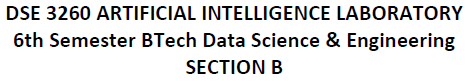

## Kartabya Krishna
## RegNo: 210968244
## Week: 09
## Date: 20240325

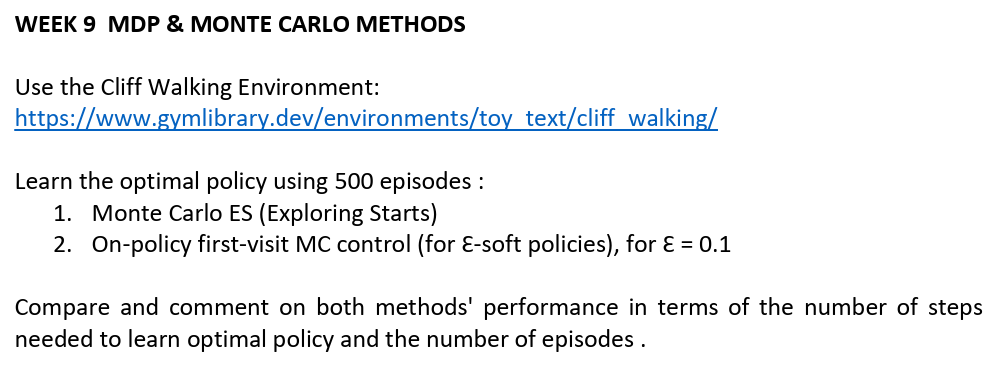

# Cliff Walking

![cliff_walking.gif](attachment:cliff_walking.gif)


## Action Space

- **Discrete(4)**

## Observation Space

- **Discrete(48)**

## Import

```python
import gym
env = gym.make("CliffWalking-v0")
```

## Description

This is a simple implementation of the Gridworld Cliff reinforcement learning task, adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction by Sutton and Barto, with inspiration from [this repository](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py).

The board is a **4x12 matrix** with the following layout using NumPy matrix indexing:

- **[3, 0] as the start at bottom-left**
- **[3, 11] as the goal at bottom-right**
- **[3, 1..10] as the cliff at bottom-center**

If the agent steps on the cliff, it returns to the start. An episode terminates when the agent reaches the goal.

## Actions

There are 4 discrete deterministic actions:

- **0: move up**
- **1: move right**
- **2: move down**
- **3: move left**

## Observations

There are **3x12 + 1** possible states. The agent cannot be at the cliff nor at the goal, as this results in the end of the episode. Therefore, it remains all the positions of the first 3 rows plus the bottom-left cell. The observation is simply the current position encoded as a flattened index.

## Reward

Each time step incurs **-1** reward, and stepping into the cliff incurs **-100** reward.

In [1]:
import gym
import numpy as np

## Creating the Environment

In [ ]:
env = gym.make('CliffWalking-v0')

---

# Monte Carlo Implementation

Monte Carlo methods are a class of reinforcement learning algorithms that rely on repeated random sampling (Monte Carlo simulations) to estimate numerical results. In the context of reinforcement learning, Monte Carlo methods are used to estimate the value of states or state-action pairs by averaging the returns observed from multiple episodes.

## How Monte Carlo Works

1. **Exploring Starts**:
   - Monte Carlo methods often utilize the concept of exploring starts, where episodes begin from a randomly selected state-action pair. This encourages exploration of different parts of the state-action space.
   
2. **Episode Generation**:
   - Each episode consists of the agent interacting with the environment from a starting state to a terminal state (end of episode), collecting transitions of state-action-reward tuples along the way.
   
3. **Reward Accumulation**:
   - During each episode, rewards are accumulated as the agent navigates through the environment. These rewards contribute to the total return for the episode.
   
4. **Update Q-values**:
   - After an episode is complete, the observed state-action-reward transitions are used to update the Q-values in the Q-table. This is done using the incremental update formula, where the new Q-value is a weighted sum of the old Q-value and the observed return.
   
5. **Policy Improvement**:
   - Once all episodes are completed, the optimal policy is derived from the learned Q-values. The policy selects the action with the maximum Q-value for each state.

In [3]:
def monte_carlo_es(env, n_episodes=500):
    # Initialize Q table and visit count table
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    N = np.zeros((env.observation_space.n, env.action_space.n))
    gamma = 1.0  # discount factor
    total_steps = []  # track total steps per episode

    # Iterate through a fixed number of episodes
    for i in range(n_episodes):
        state = env.reset()  # Reset environment to start state
        episode = []  # Store episode transitions
        done = False  # Termination flag for episode
        steps = 0  # Track number of steps in current episode

        # Generate an episode using exploring starts
        while not done:
            action = np.random.choice(env.action_space.n)  # Choose a random action
            next_state, reward, done, info = env.step(action)  # Take the action
            episode.append((state, action, reward))  # Store the transition
            state = next_state  # Move to the next state
            steps += 1  # Increment step count
        total_steps.append(steps)  # Record total steps for the episode

        # Update Q values using the episode (Monte Carlo method)
        returns = 0  # Initialize return
        for j in range(len(episode)-1, -1, -1):  # Traverse the episode in reverse order
            state, action, reward = episode[j]
            returns = gamma * returns + reward  # Update return
            N[state][action] += 1  # Increment visit count for state-action pair
            # Update Q value using incremental update formula
            Q[state][action] += (returns - Q[state][action]) / N[state][action]

    # Derive optimal policy from Q values
    policy = np.argmax(Q, axis=1)

    return policy, Q, total_steps

### Code Explanation
- This function implements Monte Carlo Exploring Starts (ES) algorithm for finding an optimal policy in a given environment.
- It iterates through a fixed number of episodes, during which it learns and updates the action values in the Q-table.
- In each episode, it starts with a random initial state-action pair (exploring starts) and explores the environment until termination.
- The rewards obtained during an episode are used to update the Q-values using the incremental update formula.
- After all episodes, the function derives the optimal policy by selecting the action with the maximum Q-value for each state.
- It returns the derived optimal policy, the Q-table, and the total number of steps taken in each episode.

---

# On-Policy First-Visit Monte Carlo Control with ε-Soft Policies

On-policy first-visit Monte Carlo control is a reinforcement learning algorithm used to find the optimal policy directly from the environment by following a single policy. It estimates the action values for the current policy and updates the policy towards greediness with respect to the estimated values. This approach ensures that the policy being learned is the same policy being used to generate behavior. Additionally, it follows the first-visit Monte Carlo approach, where only the first occurrence of a state-action pair in an episode is considered for update.

## What is On-Policy?

- In on-policy methods, the policy used to select actions for exploration is the same policy being evaluated and improved.
- This means that during learning, the agent explores the environment and updates its policy based on its own actions.

## First-Visit Monte Carlo Approach

- The first-visit Monte Carlo approach considers only the first occurrence of a state-action pair in an episode for update.
- This ensures that each update is based on independent samples, preventing bias in the estimates.

## How On-Policy First-Visit Monte Carlo Control Works

1. **Initialize Q-Values and Visit Counts**:
   - Initialize Q-table and visit count table to store action values and visit counts for each state-action pair.

2. **Episode Iteration**:
   - Iterate through a fixed number of episodes, during which the agent interacts with the environment.

3. **Generate Episode Using ε-Soft Policy**:
   - For each step in the episode, choose actions based on an ε-soft policy.
   - With probability ε, choose a random action (exploration).
   - With probability 1-ε, choose the action with the maximum Q-value (exploitation).

4. **Update Q-Values (First-Visit Monte Carlo)**:
   - After each episode, update the Q-values using the first-visit Monte Carlo approach.
   - Only consider the first occurrence of each state-action pair in the episode for update.

5. **Policy Improvement**:
   - Derive the optimal policy by selecting the action with the maximum Q-value for each state after all episodes are completed.

6. **Return Policy, Q-Table, and Total Steps**:
   - Return the derived optimal policy, the Q-table containing action values, and the total number of steps taken in each episode.


In [4]:
def on_policy_mc_control(env, n_episodes=500, epsilon=0.1):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    N = np.zeros((env.observation_space.n, env.action_space.n))
    gamma = 1.0
    total_steps = []

    for i in range(n_episodes):
        state = env.reset()
        done = False
        steps = 0

        # generate an episode using Ɛ-soft policy
        while not done:
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])
            next_state, reward, done, info = env.step(action)
            N[state][action] += 1
            Q[state][action] += (reward + gamma*np.max(Q[next_state]) - Q[state][action])/N[state][action]
            state = next_state
            steps += 1
        total_steps.append(steps)

    # derive optimal policy from Q values
    policy = np.argmax(Q, axis=1)

    return policy, Q, total_steps

### Code Explanation:
- This function implements On-Policy Monte Carlo Control algorithm, which is used to find an optimal policy in reinforcement learning.
- It iterates through a fixed number of episodes, during which it learns and updates the action values in the Q-table.
- In each episode, it follows an ε-soft policy, where ε represents the probability of selecting a random action for exploration.
- The ε-soft policy balances exploration and exploitation, ensuring that the agent explores different parts of the state-action space while also exploiting its current knowledge.
- After each action, the Q-value for the current state-action pair is updated using the incremental update formula.
- The function derives the optimal policy by selecting the action with the maximum Q-value for each state after all episodes are completed.
- It returns the derived optimal policy, the Q-table, and the total number of steps taken in each episode.

---

## Calling the Functions 

In [5]:
monte_carlo_es_policy, monte_carlo_es_q, total_steps_es = monte_carlo_es(env)
on_policy_mc_control_policy, on_policy_mc_control_q, total_steps_control = on_policy_mc_control(env)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [6]:
print(str.format('Total Number of Steps taken to reach Optimal Policy using Monte Carlo ES: {}', sum(total_steps_es)))
print(str.format('Total Number of Steps taken to reach Optimal Policy using On-Policy First-Visit MC Control: {}', sum(total_steps_control)))

Total Number of Steps taken to reach Optimal Policy using Monte Carlo ES: 3484417
Total Number of Steps taken to reach Optimal Policy using On-Policy First-Visit MC Control: 18064


In [7]:
print(str.format('Average Number of Steps per Episode taken to reach Optimal Policy using Monte Carlo ES: {}', sum(total_steps_es)/len(total_steps_es)))
print(str.format('Average Number of Steps per Episode taken to reach Optimal Policy using On-Policy First-Visit MC Control: {}', sum(total_steps_control)/len(total_steps_control)))


Average Number of Steps per Episode taken to reach Optimal Policy using Monte Carlo ES: 6968.834
Average Number of Steps per Episode taken to reach Optimal Policy using On-Policy First-Visit MC Control: 36.128


1. **Total Number of Steps taken to reach Optimal Policy**:
   - Monte Carlo ES: ***3,484,417 steps***
   - On-Policy First-Visit MC Control: ***18,064 steps***

   **Interpretation**: The total number of steps required for On-Policy First-Visit MC Control to learn the optimal policy is significantly lower compared to Monte Carlo ES. This suggests that On-Policy First-Visit MC Control is more efficient in terms of the total number of actions required to achieve the optimal policy.

2. **Average Number of Steps per Episode taken to reach Optimal Policy**:
   - Monte Carlo ES: ***6,968.834 steps per episode***
   - On-Policy First-Visit MC Control: ***36.128 steps per episode***

   **Interpretation**: On average, each episode of On-Policy First-Visit MC Control required considerably fewer steps to learn the optimal policy compared to Monte Carlo ES. This indicates that On-Policy First-Visit MC Control learns more rapidly within each episode, making it a more efficient algorithm for learning the optimal policy.

In summary, both statistics suggest that On-Policy First-Visit MC Control outperforms Monte Carlo ES in terms of efficiency. It achieves the optimal policy with significantly fewer total steps and fewer steps per episode, demonstrating its superior performance in learning the optimal policy in a more efficient manner.